In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.stats as astats
from astropy import units as u
from mpl_toolkits.axes_grid1 import AxesGrid
import sys
from matplotlib.path import Path
from scipy import interpolate
from colorspacious import cspace_convert
from astropy.coordinates import ICRS, Galactic
from astropy.coordinates import Angle, Latitude, Longitude

In [3]:
field_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','33','62','130','131','132','133','134','135','136','137','138','139','140','141','142','143','144','145','147','148','149','150','176','177','178','179','180','181']
model_list = ['mesa']
coeff_list = ['decam']

In [23]:
# We want to have a file with the basic data of each field summarized. So far, this data includes:
#   - Field number
#   - Degrees from SMC centre
#   - Position Angle
#   - Area in deg^2
coord_list = read_txt('/scratch/SMASH_DATA/smash_fields_final.txt', cols = (0,4,5))
field_coord_SMC = np.array(coordinate_calculator(coord_list))

inner_radius = np.where(field_coord_SMC[:,1]< 15)
inner_fields = field_coord_SMC[inner_radius,0]
field_list = [str(int(x)) for x in inner_fields[0]]

field_coord_SMC = np.array(coordinate_calculator(coord_list))
field_coord_SMC.shape = len(field_list), 3
print(field_coord_SMC.shape)

NameError: name 'coordinate_calculator' is not defined

In [7]:
areas_file = np.loadtxt('/scratch/SMASH_DATA/Field_area_info.txt')
areas = areas_file.T[1]
print(areas_file)

[[  1.     2.39]
 [  2.     2.55]
 [  3.     2.77]
 [  4.     1.07]
 [  5.     2.78]
 [  6.     2.7 ]
 [  7.     2.76]
 [  8.     2.49]
 [  9.     1.22]
 [ 10.     2.68]
 [ 11.     2.77]
 [ 12.     2.82]
 [ 13.     2.69]
 [ 14.     2.79]
 [ 15.     2.78]
 [ 16.     2.81]
 [ 17.     2.61]
 [ 18.     2.64]
 [ 19.     2.42]
 [ 20.     2.32]
 [ 21.     2.42]
 [ 22.     2.54]
 [ 23.     2.35]
 [ 24.     2.06]
 [ 25.     2.35]
 [ 26.     2.52]
 [139.     2.54]
 [141.     2.4 ]
 [142.     2.63]
 [143.     2.35]
 [144.     2.57]
 [145.     2.55]
 [147.     2.25]
 [148.     2.17]
 [149.     2.67]
 [150.     2.42]
 [176.     2.79]
 [177.     2.8 ]
 [178.     2.87]
 [181.     2.3 ]]


In [8]:
xbinsize = 0.1
ybinsize = 0.3
xbins = np.arange( start = -1, stop = 2, step = xbinsize)
ybins = np.arange( start = 14, stop = 24, step = ybinsize)

# Respectively u,g,r,i,z. Ex: u0 = u - 4.239*E(B-V)
extinction_coeff_sdss = np.array([4.239, 3.303, 2.285, 1.698, 1.263])
# Respectively u,g,r,i,z,Y. Ex: A_u = R_u*EBV_SFD98 ; u0 = u - A_u
extinction_coeff_decam = np.array([3.9631, 3.1863, 2.1401, 1.5690, 1.1957, 1.0476])

vertex_coord = [(-1,14),(-1,20),(0,24),(0.9,24),(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
halo_vertex_coord = [(0.2, 18), (0.4, 18), (0.4, 19), (0.2, 19)] # This is what defines the vertices of the region to be defined.

In [9]:
# Opens a SMASH fits file and stores the data in the field_data variable. This variable is a XRx36C array with the following columns:
# 0-ID 1-RA 2-DEC 3-RAERR 4-DECERR 5-RASCATTER 6-DECSCATTER 7-NDET 8-DEPTHFLAG 9-SRCINDX 10-SRCFINDX 11-U 12-UERR 13-USCATTER 14-NDETU 15-G 16-GERR 17-GSCATTER 18-NDETG 19-R 20-RERR 21-RSCATTER 22-NDETR 23-I 24-IERR 25-ISCATTER 26-NDETI 27-Z 28-ZERR 29-ZSCATTER 30-NDETZ 31-CHI 32-SHARP 33-FLAG 34-PROB 35-EBV
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data, header

In [10]:
# Opens a text file and stores the data in field_data.
def read_txt (name, cols = None):
    field_data = np.loadtxt(name, comments='#', usecols = cols)
    return field_data.T

In [11]:
# Function that dereddenes a set of magnitudes. It uses the standard method and the user has to decide which coefficients wants to use.
# By default, it uses the filters of DECam
def dereddener(mag, filter_index, EBV, field_number, filterset = 'decam'):
    
    if field_number == '5' or field_number == '6' or field_number == '9' or field_number == '10' or field_number == '11':
        EBV[np.where(EBV > 0.3)] = 0.037 #This line is to ensure we don't have unrealistic extinction values in the SMC centre. The limit is debatable.
    if filterset == 'decam':
        return mag - extinction_coeff_decam[filter_index]*EBV
    else:
        return mag - extinction_coeff_sdss[filter_index]*EBV

In [24]:
# Function that applies a completeness correction to the MW models in SMASH.
# Input: the number of the field we're dealing with (field_number) and the data in the file of the model.
# Output: A 2D histogram representing the corrected CMD of the model within the stablished colour and mag limits.
# Global variables: xbins and ybins.
def completeness_corrector(field_number, model, area):
    name_field_complete = '/scratch/SMASH_DATA/Field%s_complete_stars.fits.gz' % (field_number)
    complete, header = read_fits(name_field_complete)
    
    # Applying the completeness to the data.
    # Step 1. Retrieving the completeness data available.
    magG_complete = complete['INP_G']
    magI_complete = complete['INP_I']
    recovered = complete['RECOVERED']
    
    # Step 2. Construct two sets of data. One for the recovered stars and one for the whole dataset.
    not_recovered_indeces = np.where(recovered == 0)
    magG_recovered, magI_recovered = np.delete(magG_complete, not_recovered_indeces), np.delete(magI_complete, not_recovered_indeces)
    recovered_data = np.vstack([magG_recovered - magI_recovered, magG_recovered])
    complete_data = np.vstack([magG_complete - magI_complete, magG_complete])
    
    # Step 3. Construct histograms for the 2 sets.
    hist2d_complete = np.histogram2d(complete_data[0], complete_data[1], bins = [xbins,ybins])
    hist2d_recovered = np.histogram2d(recovered_data[0], recovered_data[1], bins = [xbins,ybins])
    #hist2d_complete, hist2d_recovered = np.array(hist2d_complete), np.array(hist2d_recovered)
    
    # Step 4. To make sure we have data everywhere we're studying we set the unfilled bins with a 100% completion.
    hist2d_complete[0] [hist2d_complete[0] == 0.] = 1.0
    hist2d_recovered[0] [hist2d_complete[0] == 0.] = 1.0
    
    # Step 5. We compute the recovered ratio and apply it to the model.
    recovered_ratio = np.divide(hist2d_recovered[0], hist2d_complete[0])
    corrected_model = model * recovered_ratio
    
    #Step 6. We have to take into account that the model uses an area of 3 deg^2, so we also have to correct for that.
    corrected_model = corrected_model * (area/3.0)
    
    return corrected_model

In [25]:
# Function that gets out a scaling factor for the model that depends exclusively on the galactic latitude.
# This is made to reduce the errors in the subtraction of the model.
def galactic_latitude_model_scaler(field_number, population):
    # First we need to get the galactic coordinates for our field.
    coord_list = read_txt('/scratch/SMASH_DATA/smash_fields_final.txt', cols = (0,4,5))
    for field in coord_list.T:
        #print field_number
        if field[0] == float(field_number):
            #print 'hola'
            field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
            b_field = field_coord.galactic.b.deg
            break
    # Good, now let's find the galactic latitude for the centre of the SMC.
    SMC_center = SkyCoord('0h52m44s', '-72d49m42s')
    b_smc = SMC_center.galactic.b.deg
    # Well that was easy. Now the final bit. Return the value of scaling corresponding to the right population.
    # The numbers are taken based on an analysis from its dependance to the b coordinate without any scaling.
    if population == 'young':
        return np.exp(0.0291*(b_field - b_smc))
    if population == 'old':
        return np.exp(0.05695*(b_field - b_smc))
    if population == 'all':
        return np.exp(0.02436*(b_field - b_smc))

In [21]:
# Computes a 2D histogram of observed CMD and MW model CMD and subtracts the later to the fisrt one. Then, plots the result.
def cmd_subtractor (data, model, field_number, model_name, filterset, area, population, halo_scaling = False):
    magG = data['G']
    magI = data['I']
    star_prob = data['PROB']
    EBV = data['EBV']
    coordinates = data['RA'], data['DEC']

    magG_0, magI_0 = dereddener(magG, 1, EBV, field_number), dereddener(magI, 3, EBV, field_number)
    GminusI = magG_0 - magI_0
    cmd_data = np.vstack([GminusI, magG_0])
    #cmd_data = np.array(cmd_data)
# Remove blue stars, possibly white dwarfs. These stars are too blue to be stars from a MC.
    bad_indeces = np.where(cmd_data[0] < -1)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove faint stars beyond the threshold of the model. We don't have information of how the MW affects our data at this point. In this way we are able to reduce the errors in the data sample.
    bad_indeces = np.where(cmd_data[1] > 24)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove red stars where MW models are known to fail and where there is no expectation of MC stars.
    bad_indeces = np.where(cmd_data[0] > 2)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove bright stars.
    bad_indeces = np.where(cmd_data[1] < 14)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove objects with low stellaricity probability
    #bad_indeces = np.where(star_prob <= 0.6)
    #cmd_data = np.delete(cmd_data, bad_indeces, 1)


# We want first to scale the model to the data. We only want to scale the halo stars in the model since this is the most crucial component that is affecting our results. 
    #halo_scaling_factor = halo_scaler(model, magG_0, magI_0, field_number, area)
    #print(halo_scaling_factor)
    
# We are going to separate the sample in halo and not halo. To apply the scaling to the halo alone.
    model_halo = np.delete(model, np.where(model[8] == 9.) , 1)
    model_rest = np.delete(model, np.where(model[8] < 9.) , 1)

    
    hist2d_data = np.histogram2d(cmd_data[0], cmd_data[1], bins = [xbins,ybins])
    hist2d_model_halo = np.histogram2d((model_halo[1] - model_halo[3]), model_halo[1], bins = [xbins,ybins])
    hist2d_model_rest = np.histogram2d((model_rest[1] - model_rest[3]), model_rest[1], bins = [xbins,ybins])

# In order for our uncertainties to be realistic we need to do a model scaling according to the galactic latitude.
# Here we are going to find the value for this scaling that applies to the specific field and population chosen.
    b_scaling = galactic_latitude_model_scaler(field_number, population)
    #print b_scaling
    
    # Applying the completeness to the data.
    # Step 1. Retrieving all the simulated stars. We use input magnitudes because they are available for all the stars, even the not recovered.
    
    #magG_complete = complete['INP_G']
    #magI_complete = complete['INP_I']
    #recovered = complete['RECOVERED']
    #not_recovered_indeces = np.where(recovered == 0)
    #magG_recovered, magI_recovered = np.delete(magG_complete, not_recovered_indeces), np.delete(magI_complete, not_recovered_indeces)
    #recovered_data = np.vstack([magG_recovered - magI_recovered, magG_recovered])
    #complete_data = np.vstack([magG_complete - magI_complete, magG_complete])    
    #hist2d_complete = np.histogram2d(complete_data[0], complete_data[1], bins = [xbins,ybins])
    #hist2d_recovered = np.histogram2d(recovered_data[0], recovered_data[1], bins = [xbins,ybins])
    #hist2d_complete, hist2d_recovered = np.array(hist2d_complete), np.array(hist2d_recovered)
    #hist2d_complete[0] [hist2d_complete[0] == 0.] = 1.0
    #hist2d_recovered[0] [hist2d_complete[0] == 0.] = 1.0
    #recovered_ratio = np.divide(hist2d_recovered[0], hist2d_complete[0])
    
#    print min(complete_data[0]),max(complete_data[0]),max(complete_data[1]),min(complete_data[1])
#    print min(cmd_data[0]), max(cmd_data[0]), max(cmd_data[1]), min(cmd_data[1])
#    recovered_ratio = np.reshape(recovered_ratio, -1)
#    plt.imshow(recovered_ratio.T, extent = (min(complete_data[0]),max(complete_data[0]),max(complete_data[1]),min(complete_data[1])), aspect = 'auto', origin = 'upper')
#    plt.colorbar()
#    plt.show()


# IMPORTANT LINES BELOW!!! With these lines we correct the data with the model.
# The correction is separated between halo correction or b correction, so I can scale both things independently.
# Or don't scale them at all.
    if halo_scaling == True:
        hist2d = hist2d_data[0] - halo_scaling_factor * completeness_corrector(field_number, hist2d_model_halo[0], area) - completeness_corrector(field_number, hist2d_model_rest[0], area)
    else:
        hist2d = hist2d_data[0] - b_scaling*(completeness_corrector(field_number, hist2d_model_halo[0], area) + completeness_corrector(field_number, hist2d_model_rest[0], area))

# Apply a strong cut, where we do not take into account stars that are below the noise level created by subtracting the model from the data, i.e. the values that are below a threshold set by the lowest negative value in the sample.
#    print np.amin(hist2d)
#    hist2d [hist2d < abs(np.amin(hist2d))] = np.nan
# Useful command for plotting.
    hist2d [hist2d == 0.] = np.nan

# Set the overall figure for the CMD plotting
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure()
    ax = fig.add_subplot(111)

#    print np.nanmax(hist2d)/(np.nanmax(hist2d) + abs(np.nanmin(hist2d)))
    hist_final = ax.imshow(hist2d.T, extent = (min(cmd_data[0]),max(cmd_data[0]),min(cmd_data[1]),max(cmd_data[1])), aspect = 'auto', origin = 'lower', cmap = 'viridis_r', norm = colors.SymLogNorm(1), interpolation = 'none') #, norm = colors.SymLogNorm(0.1)

    plt.gca().invert_yaxis()
    plt.ylabel('g')
    plt.xlabel('g-i')
    cbd = plt.colorbar(hist_final)
    plt.title('Field %s' % (field_number))
    plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/CMD_%s_%s.png' % (field_number, model_name))
#    plt.show()
    plt.close()
    return hist2d, hist2d_data

In [20]:
# Surface brightness calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def surface_brightness_calculator(corrected_data, original_data, field_number, model, coordinates, data_set, field_area):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':20})
    fig = plt.figure(figsize= (12,9))
    ax = fig.add_subplot(111)

    hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'viridis_r', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    vertex_list = [list(x) for x in vertex_coord]
    vertex_array = np.array(vertex_list)
    polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
    ax.add_patch(polygon)
    #vertex_list = [list(x) for x in halo_vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.4, color = 'purple')
    #ax.add_patch(polygon)
    plt.ylabel('$g$')
    plt.xlabel('$g-i$')
    plt.minorticks_on()
    cbd = plt.colorbar(hist_final)
    cbd.set_label('Star Counts')
    plt.title('Field %s' % (field_number))

    plt.tight_layout()
    plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/CMD_modelzone_field%s_%s_%s.png' % (field_number, model, data_set))
    plt.close()


    
    #Code for computing the SMC+MW SB.
    cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    total_stars = np.sum(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    flux_arcsec = total_flux / field_area_arcsec
    mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    #Code for computing the MW SB.
    
    #model_stars_per_mag = np.nansum(cut_corrected_model, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    #model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    
    return mag_arcsec, total_flux, total_stars


In [26]:
# Function to retrieve the surface brightness of the model for each field.
def model_SB(model):
        
    model_g = model[1]
    model_gi = model[1] - model[3]
    
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    
    model_2dhist, xedges, yedges = np.histogram2d(model_gi, model_g, bins = [xbins,ybins])
    
    cut_model_out = np.ma.masked_array(model_2dhist, mask=grid.T)
    grid = ~np.array(grid)
    cut_model_in = np.ma.masked_array(model_2dhist, mask=grid.T)
    
    stars_per_mag = np.nansum(cut_model_in, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    flux_in = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    stars_per_mag = np.nansum(cut_model_out, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    flux_out = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    return flux_in, flux_out

In [27]:
# Function that constructs the SB profile based on the retrieved magnitudes and the radial distance from the center of the SMC.
def SB_profile(fields_data, fields_errors, fields_coord, model, filterset):

    distance_SMC = 62 #kpc
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':24})
    plt.rcParams.update({'errorbar.capsize': 4})
    fig = plt.figure(figsize= (12,9))
    ax = fig.add_subplot(111)

    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256,3))*60
    color_circle[:,1] = np.ones((256))*45
    color_circle[:,2] = np.arange(0,360,360.0/256.0)
    color_circle_rgb = cspace_convert(color_circle, "JCh","sRGB1")
    cm2 = colors.ListedColormap(color_circle_rgb)
    
    fields_coord = fields_coord.T
    plot = ax.scatter(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, c = fields_coord[2], cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, yerr = fields_errors, fmt='none', zorder=1, c='k')
    #for i, field_number in enumerate(fields_coord[0]):
    #    plt.annotate(field_number, (str(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC), str(fields_data)))
    cb = plt.colorbar(plot)
    cb.set_label('Position Angle ($^\circ$)')
    plt.xlim(xmin=0)
    plt.ylim(ymin=23, ymax=31)
    plt.xlabel('$r$ (kpc)')
    plt.ylabel('$g$ (mag/arcsec$^2$)')
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.tight_layout()
    plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/SB_profile_15deg_errors_%s_%s_13D.pdf' % (model, filterset))
    plt.close()


In [35]:
distance_SMC = 62#kpc
# Plot the SB stored in files.
for filterset in coeff_list:
    for model_name in model_list:
        SB_data = np.loadtxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_13D.dat' % (model_name, filterset))
        fields_data = SB_data[:,3]
        fields_errors = SB_data[:,4]
        fields_coord = np.array((SB_data[:,0], SB_data[:,1], SB_data[:,2]))
        #print fields_data.shape, fields_coord.shape
        SB_profile(fields_data, fields_errors, fields_coord.T, model_name, filterset)
        #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_profile_info_%s_%s_19S.dat' % (model_name, filterset), np.stack((field_coord_SMC[:,0], np.tan(np.deg2rad(field_coord_SMC[:,1]))*distance_SMC, field_coord_SMC[:,2], areas, fields_data, fields_errors)).T, header='Field_number Distance_SMC(kpc) PA(deg) Area(deg^2) SB(mag/arcsec^2) SB_error(mag/arcsec^2)', fmt= '%.0f %.3f %.3f %.5f %.5f %.5f')

In [28]:
# It returns, for a given set of SMASH fields, the values of its position angle (PA) and distance (rho), in degrees, to the SMC center.
# field_list is a 1D array with the numbers of the fields in STRINGS
# coordinates_data is a 2D array with 3 columns one for the name of the field and the other two for its RA and DEC, in this order and in degrees.
def coordinate_calculator (coordinates_data):
    SMC_center = SkyCoord('0h52m44s', '-72d49m42s')
    LMC_center = SkyCoord('05h27m36s', '-69d52m0s')
    field_list_2 = np.array([int(x) for x in field_list])
    coordinates_data = coordinates_data.T
    coordinates = []
    for field in coordinates_data:
        for selected in field_list_2:
            if field[0] == selected:
                field_data = []
                field_data.append(selected)
                field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
                # We use the rules described in Van der Marel & Cioni 2001 to compute the distance to the center of the SMC. We need to know both sinPA and cosPA to be able to determine in which quadrant is the angle.
                rho = np.arccos(np.cos(field_coord.dec.radian) * np.cos(SMC_center.dec.radian) * np.cos(field_coord.ra.radian - SMC_center.ra.radian) + np.sin(field_coord.dec.radian) * np.sin(SMC_center.dec.radian))
                field_data.append(np.rad2deg(rho))
                cosPA = -np.cos(field_coord.dec.radian) * np.sin(field_coord.ra.radian - SMC_center.ra.radian) / np.sin(rho)
                sinPA = (np.sin(field_coord.dec.radian) * np.cos(SMC_center.dec.radian) - np.cos(field_coord.dec.radian) * np.sin(SMC_center.dec.radian) * np.cos(field_coord.ra.radian - SMC_center.ra.radian)) / np.sin(rho)
                # We use the extraordinary resources of complex numbers and python functions to obtain the PA in a very cool way.
                PA = np.angle(complex(cosPA,sinPA), deg = True)
                # This line below is there to obtain the angles in the right convention, i.e. the astrophysical one.
                PA = PA - 90
                PA = np.where(PA < 0, PA + 360, PA)
                field_data.append(PA)
                coordinates.append(field_data)
    return coordinates

In [29]:
# Function to scale the number of halo stars in the model to match it to the data.
# Input: full model data with all columns (model_data), magnitudes G and I for the SMASH data (magG_0, magI_0) and field_number.
def halo_scaler (model_data, magG_0, magI_0, field_number, field_area):
    # Prepare the smash_data
    GminusI_0 = magG_0 - magI_0
    
    # Prepare the model_data
    #model_data = np.array(model_data)
    model_data = np.delete(model_data, np.where(model_data[8] < 9.) , 1) # We only want halo stars (9.0).
    modelG = model_data[1]
    modelGI = model_data[1] - model_data[3]
    
    # Step 0. Set up the overall CMD region.
    #xbins = np.arange( start = -1, stop = 2, step = xbinsize)
    #ybins = np.arange( start = 14, stop = 24, step = ybinsize)
    
    # Step 1. Create an histogram of the model and the data
    hist2d_model = np.histogram2d(modelGI, modelG, bins = [xbins,ybins])
    hist2d_data = np.histogram2d(GminusI_0, magG_0, bins = [xbins,ybins])

    # Step 2. Set up the region of interest.
    mags = hist2d_model[2][:-1] + ybinsize/2
    clrs = hist2d_model[1][:-1] + xbinsize/2
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    #vertex_coord = [(0.2, 18), (0.4, 18), (0.4, 19), (0.2, 19)] # This is what defines the vertices of the region to be defined.
    
    path = Path(halo_vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    grid = ~np.array(grid)

    # Step 3. Create a new cut histogram
    hist_model = completeness_corrector(field_number, hist2d_model[0], field_area)
    cut_hist2d_model = np.ma.masked_array(hist_model, mask=grid.T)
    cut_hist2d_data = np.ma.masked_array(hist2d_data[0], mask=grid.T)

    # Optional step. Check the results
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.rcParams.update({'font.size':16})
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    #check_hist = ax.imshow(cut_hist2d_model.T, aspect = 'auto', origin = 'upper', extent = (min(hist2d_model[1]), max(hist2d_model[1]), max(hist2d_model[2]), min(hist2d_model[2])))
    #plt.ylabel('g')
    #plt.xlabel('g-i')
    #cbd = plt.colorbar(check_hist)
    #plt.show()
    #plt.close()

    # Step 4. Counting the number of stars in the region of interest.
    stars_model = np.sum(cut_hist2d_model)
    stars_data = np.sum(cut_hist2d_data)
    #print stars_model, stars_data

    #print(stars_model/stars_data)
    
    #Step 5. Final result.
    return stars_data/stars_model
    #return 1.0

In [30]:
# Function that calculates the area in a sky region occupied by a given number of stars. The function bins the sky and counts the number of bins with data in it. The size of the bins can be changed accordingly by changing their number. The input must be a numpy array with the first 2 columns being RA and DEC in degrees.
def field_area_calculator (data, field, bin_number):
    # First of all, we must double check that the field is not in the meridian of RA=0, because this would cause problems with how the code computes the area. If it is in that meridian, we set the values in the 3rd and 4th quadrant to the 0 to -180 interval. In this way we have the values in this meridian continuous. Of course we expect to have no values in the 180 meridian cause this would cause the same problem again.
    # We will also multiply RA by cos(DEC) to avoid problems near the poles.
    if (max(data[0])-min(data[0])) > 180:
        new_ra = np.where(data[0] > 180, data[0] - 360, data[0])
        #new_ra = new_ra * np.cos(np.deg2rad(data[1]))
        #hist_coord = np.histogram2d(new_ra, data[1], bins = bins)
    else:
        #hist_coord = np.histogram2d(data[0], data[1], bins = bins)
        new_ra = data[0]
    
    # Secondly, we want to change the RA to RA*cos(DEC) to have a smaller range in this variable. And because we have to do it anyways.
    #mid_dec = (data[1][1:] + data[1][:-1]) * 0.5
    #new_ra_cosdec = new_ra * np.cos(np.deg2rad(data[1]))
    
    #binsRA = np.arange(min(new_ra), max(new_ra), binsize)
    #binsDEC = np.arange(min(data[1]), max(data[1]), binsize)
    # Then, we make an histogram of the data with the amount of bins provided.
    hist_coord = np.histogram2d(new_ra, data[1], bins = bin_number)
    
    # Then, we put nans on the zeros so that they appear white in the figure.
    hist_coord[0] [hist_coord[0] == 0.] = np.nan
    # We save a figure just to check if the histogram has enough/too much resolution.
    plt.figure(1, figsize=(16,9))
    plt.imshow(hist_coord[0])
    plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/Field%sSkyView.png' % (field))
#    plt.show()
    plt.close()


    # We first compute the area of each bin, correcting the dra variable for cos(delta), which takes into account the fact that a RA circle at DEC=0 is greater that one at DEC=80.
    dra = np.diff(hist_coord[1])
    ddec = np.diff(hist_coord[2])
    mid_dec = (hist_coord[2][1:] + hist_coord[2][:-1]) * 0.5
    dra_cosdelta = dra * np.cos(np.deg2rad(mid_dec))
    # This line below creates a 2D grid of areas, to ensure that later on every bin is multiplied for the correct amount.
    area_bin = dra_cosdelta[:, None] * ddec
    hist_coord[0] [hist_coord[0] > 0.] = 1.0
    # We sum all the bins and mulpiply for the area of each bin.
    area = np.nansum(hist_coord[0] * area_bin)
    #print 'Field %s Area (degrees^2): ' % (field), area
    return area


The next box is to plot the SB profile with the data already in files.

# Main execution of the program

In [19]:
population = ['all']
for filterset in coeff_list:
    for model_name in model_list:
        field_SB = []
        field_error = []
        field_star_counts = []
        data_field_flux = []
        print model_name, filterset 
        print ''
        for field_number, field_area in zip(field_list, areas):
            if field_number == '4' or field_number == '9' or field_number == '1':
                name_field_data = '/scratch/SMASH_DATA/Field%s_allobj_stars.fits' % (field_number)
            else:
                name_field_data = '/scratch/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
            name_field_model = '/scratch/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
            field = 'Field %s' % (field_number)
            data, header = read_fits(name_field_data)
            model = read_txt(name_field_model)
            coordinates = data['RA'], data['DEC']
            corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area, population[0])
            
            
            
            data_set = 'data'
            temp1, temp2, temp3 = surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area)
            #We need to scale the count number for the area of the field.
            temp3 = temp3 / field_area
            field_SB, data_field_flux, field_star_counts = np.append(field_SB, temp1), np.append(data_field_flux, temp3), np.append(field_star_counts, temp3)
            
            
            #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
            #model_flux_in, model_flux_out = model_SB(model)
                        
            #Now we calculate the part of the uncertainty due to the model.
            model_error = 1500 * 1500
            
            #Next the area error.
            area_error = (field_star_counts[-1]*0.1)**2 #Here we impose that the uncertainty in the area of the field is of 10%. This is a very reasonable assumption for SMASH.
            
            star_density_error = np.sqrt(model_error + area_error ) / field_area
            
            #Finally the total error in the field.
            field_error.append( (2.5/np.log(10)) * (star_density_error / field_star_counts[-1]) )
            print field_number
            print 'The SB is:', field_SB[-1], '+/-', field_error[-1]
            
            #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))
            print ''
        SB_profile(field_SB, field_error, field_coord_SMC, model_name, filterset)
        SB_data = np.stack((field_coord_SMC[:,0], field_coord_SMC[:,1], field_coord_SMC[:,2], field_SB, field_error)).T
        np.savetxt('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_13D.dat' % (model_name, filterset), SB_data, header='Field_number Distance_SMC(deg) PA(deg) SB(mag/arcsec^2) SB_error(mag/arcsec^2)', fmt= '%.0f %.3f %.3f %.5f %.5f')
        #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_29S_TeXtable.dat' % (model_name, filterset), SB_data, fmt= '%.0f & %.3f & %.3f & %.5f $\pm$ %.5f \\')
        


mesa decam



/home/pol/.local/lib/python2.7/site-packages/matplotlib/colors.py:1133: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh
/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less


1
The SB is: 28.766539788549764 +/- 0.07393714966857311

2
The SB is: 28.719665122891207 +/- 0.07378099086952031

3
The SB is: 25.119591741191556 +/- 0.039370386770126164

4
The SB is: 25.743329613885994 +/- 0.10168617959684158

5
The SB is: 24.751382395406708 +/- 0.03950020904854807

6
The SB is: 23.44807420295897 +/- 0.0402205402856991

7
The SB is: 24.978293563308807 +/- 0.039360244429446266

8
The SB is: 28.989643522854394 +/- 0.2708928234693441

9
The SB is: 26.239568276503565 +/- 0.08942607522722458

10
The SB is: 23.491574159141976 +/- 0.041290291606835096

11
The SB is: 24.14645544313511 +/- 0.03935447445957357

12
The SB is: 26.373651319427587 +/- 0.038832696869162374

13
The SB is: 28.781423255977057 +/- 0.06934052767337853

14
The SB is: 25.70387349039306 +/- 0.03913817722959468

15
The SB is: 25.096325361405395 +/- 0.03912602627426179



/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


16
The SB is: 26.218005755593357 +/- 0.039033223699007795

17
The SB is: 29.522050482171696 +/- 0.2825005436935534

18
The SB is: 27.76151389425166 +/- 0.060858573937864965

19
The SB is: 28.978269132486098 +/- 0.08995926677502969

20
The SB is: 29.978667090023112 +/- 0.3423731959170394

21
The SB is: 29.8071299581107 +/- 0.2613492547860041

22
The SB is: 29.455086576814256 +/- 0.26686735943099527

23
The SB is: 29.9103626254257 +/- 0.4420540189095665

24
The SB is: 29.546622774914564 +/- 0.3820049404794039

25
The SB is: 29.296644241215883 +/- 0.20221906314066435

139
The SB is: 29.40991197610995 +/- 0.560351104839073

141
The SB is: 29.71083138141134 +/- 0.4478845162696202

142
The SB is: 29.528474279658635 +/- 0.36629201965695574

143
The SB is: 29.98670683606782 +/- 0.5398408304215583

144
The SB is: 29.342794084316658 +/- 0.3482896134085465

145
The SB is: 29.566559613740083 +/- 0.3315843229783634

147
The SB is: 29.410182464797643 +/- 0.337162084059629

148
The SB is: 29.09285206

Test area to calculate SB for only one field

In [33]:
model_name = 'mesa'
field_number = '3'
filterset = 'decam'

field_SB = []
field_error = []
model_field_flux = []
data_field_flux = []
print(model_name, filterset)
print('')
print(field_number)
name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
field = 'Field %s' % (field_number)
data, header = read_fits(name_field_data)
model = read_txt(name_field_model)
coordinates = data['RA'], data['DEC']
bin_number = int(175 + 0.15 * (len(coordinates[0])/1000))
field_area = field_area_calculator(coordinates, field_number, bin_number)
corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area)

data_set = 'data'
temp1, temp2, temp3 = surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area)
field_SB, model_field_flux, data_field_flux = np.append(field_SB, temp1), np.append(model_field_flux, temp2), np.append(data_field_flux, temp3)
            #print field_SB[-1], model_field_flux[-1], data_field_flux[-1]
            #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
model_flux_in, model_flux_out = model_SB(model)
            #print model_flux_in, model_flux_out
            
            #Now we calculate the part of the uncertainty due to the model.
model_error = ((model_flux_in/data_field_flux[-1]) * (model_field_flux[-1]/model_flux_out))**2
          
            #Next the area error.
area_error = 0.1 * 0.1
            
            #Finally the total error in the field.
field_error.append( (2.5/np.log(10)) * np.sqrt(model_error + area_error) )
print 'The SB is:', field_SB[-1], '+/-', (2.5/np.log(10)) * np.sqrt(model_error + area_error)
            
            #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))

('mesa', 'decam')

3


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


The SB is: 25.125920185547677 +/- 0.11073593574258418


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


------------------------------------------------

# Getting number of counts instead of SB

In [15]:
# Star count calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def star_count_calculator(corrected_data, original_data, field_number, model, coordinates, data_set, field_area):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T

    #vertex_coord = [(-1,14),(-1,22),(0,24),(1.5,24),(0.8,23),(1,20),(1.7,18),(1.7,17),(0.8,18),(0.4,18),(0.4,21),(0,19),(-0.5,16),(-0.5,14),(-1,14)]
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.rcParams.update({'font.size':20})
    #fig = plt.figure(figsize= (12,8))
    #ax = fig.add_subplot(111)

    #hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'viridis_r', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    #vertex_list = [list(x) for x in vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
    #ax.add_patch(polygon)
    #vertex_list = [list(x) for x in halo_vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.4, color = 'red')
    #ax.add_patch(polygon)
    #plt.ylabel('$g$')
    #plt.xlabel('$g-i$')
    #cbd = plt.colorbar(hist_final)
    #plt.title('Field %s' % (field_number))

    #plt.tight_layout()
    #plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_modelzone_field%s_%s_%s.png' % (field_number, model, data_set))
    #plt.close()


    
    #Code for computing the SMC+MW SB.
    cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    #print(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    total_stars = np.sum(stars_per_mag)
    flux_arcsec = total_flux / field_area_arcsec
#    print flux_arcsec
    mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    
    
    #Code for computing the MW SB.
    model_stars_per_mag = np.nansum(cut_corrected_model, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    total_model_stars = np.sum(model_stars_per_mag)
    
    return total_stars, total_model_stars


In [16]:
# Function to retrieve the surface brightness of the model for each field.
def model_star_counts_function(model):
        
    model_g = model[1]
    model_gi = model[1] - model[3]
    
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    
    model_2dhist, xedges, yedges = np.histogram2d(model_gi, model_g, bins = [xbins,ybins])
    
    cut_model_out = np.ma.masked_array(model_2dhist, mask=grid.T)
    grid = ~np.array(grid)
    cut_model_in = np.ma.masked_array(model_2dhist, mask=grid.T)
    
    stars_per_mag = np.nansum(cut_model_in, 0)
    model_stars_in = np.sum(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    #flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #flux_in = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    stars_per_mag = np.nansum(cut_model_out, 0)
    model_stars_out = np.sum(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    #flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #flux_out = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    return model_stars_in, model_stars_out

In [17]:
# Function that constructs the SB profile based on the retrieved magnitudes and the radial distance from the center of the SMC.
def StarCounts_profile(fields_data, fields_errors, fields_coord, model, filterset):

    distance_SMC = 62 #kpc
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure(figsize= (8,5))
    ax = fig.add_subplot(111)

    fields_coord = fields_coord.T
    plot = ax.scatter(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, c = fields_coord[2], cmap=cm.coolwarm, vmin = 0, vmax = 360, s = 35, zorder=10)
    plt.errorbar(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, yerr = fields_errors, fmt='none', zorder=1)
    #for i, field_number in enumerate(fields_coord[0]):
    #    plt.annotate(field_number, (str(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC), str(fields_data)))
    cb = plt.colorbar(plot)
    cb.set_label('Position Angle')
    plt.xlim(xmin=0)
    #plt.ylim(ymin=23, ymax=32)
    plt.yscale('log')
    plt.xlabel('r (kpc)')
    plt.ylabel('log(Star Counts)')
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/StarCounts_profile_15deg_errors_%s_%s.pdf' % (model, filterset))
    plt.close()

In [39]:
for filterset in coeff_list:
    for population in population_list:
        field_star_counts = []
        field_error = []
        model_star_counts = []
        data_field_flux = []
        print model_name, filterset 
        print ''
        for field_number, field_area in zip(field_list, areas):
            if field_number == '4' or field_number == '9' or field_number == '1':
                name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field_number)
            else:
                name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
            name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
            field = 'Field %s' % (field_number)
            data, header = read_fits(name_field_data)
            model = read_txt(name_field_model)
            coordinates = data['RA'], data['DEC']
            corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area)
            
            
            
            data_set = 'data'
            temp1, temp2 = star_count_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area)
            
            #We need to scale the count number for the area of the field.
            #We will consider a whole field to have 3 deg^2 and scale to this.
            temp1 = temp1 * (3.0 / field_area)
            
            field_star_counts, model_star_counts = np.append(field_star_counts, temp1), np.append(model_star_counts, temp2)
            
            #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
            model_star_counts_in, model_star_counts_out = model_star_counts_function(model)
            #print model_flux_in, model_flux_out
            
            #Now we calculate the part of the uncertainty due to the model.
            #model_error = ((model_flux_in/data_field_flux[-1]) * (model_field_flux[-1]/model_flux_out))**2
            
            #Next the area error.
            #area_error = 0.0
            
            #Finally the total error in the field.
            # POISSONIAN ERROR
            #field_error.append( np.sqrt(field_star_counts[-1]) )
            field_error.append( model_star_counts[-1] )
            print field_number
            print 'The star count is:', field_star_counts[-1], '+/-', field_error[-1]
            
            #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))
            print ''
        StarCounts_profile(field_star_counts, field_error, field_coord_SMC, model_name, filterset)
        SB_data = np.stack((field_coord_SMC[:,0], field_coord_SMC[:,1], field_coord_SMC[:,2], field_star_counts, field_error)).T
        np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/StarCounts_data_errors_%s_%s_15deg_22N.dat' % (model_name, filterset), SB_data, header='Field_number Distance_SMC(deg) PA(deg) SB(mag/arcsec^2) SB_error(mag/arcsec^2)', fmt= '%.0f %.3f %.3f %.5f %.5f')
        #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_29S_TeXtable.dat' % (model_name, filterset), SB_data, fmt= '%.0f & %.3f & %.3f & %.5f $\pm$ %.5f \\')
        


mesa decam



/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


1
The star count is: 31245.036487618137 +/- 6261.296761428346

2
The star count is: 30393.18582001978 +/- 9487.835048536886

3
The star count is: 1111754.7263635765 +/- 10786.841474676514

4
The star count is: 689902.7659382187 +/- 1890.2356893633869

5
The star count is: 1450788.2951870547 +/- 15392.478671801051

6
The star count is: 2192618.263290259 +/- 41766.14796862689

7
The star count is: 1346785.8071400898 +/- 15684.797176046426

8
The star count is: 8290.05859743829 +/- 9941.09879747337

9
The star count is: 457225.4961069686 +/- 2158.1606973707426

10
The star count is: 2317276.9314893615 +/- 39755.95988048466

11
The star count is: 1561000.2316166896 +/- 23598.32728477585

12
The star count is: 448554.6257823066 +/- 10922.31597677268

13
The star count is: 32039.47181567902 +/- 9069.369108944264

14
The star count is: 689099.7745139778 +/- 10102.46506658676

15
The star count is: 745460.3662768515 +/- 13422.133733872268



/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


16
The star count is: 389330.3848208703 +/- 8849.033008253338

17
The star count is: 9204.048838505529 +/- 12369.171177436932

18
The star count is: 40336.59242633068 +/- 8397.105915868773

19
The star count is: 26343.269370175058 +/- 9872.44567078588

20
The star count is: 5835.440698410147 +/- 4881.300000055523

21
The star count is: 7304.296897285016 +/- 8157.721315537685

22
The star count is: 7473.403572196993 +/- 5681.230186764598

23
The star count is: 4486.80032685649 +/- 7323.325520354651

24
The star count is: 6478.110534827093 +/- 5368.948245389816

25
The star count is: 11550.154806365226 +/- 9643.874039244445

139
The star count is: 6951.311767401014 +/- 11274.273824839443

141
The star count is: 6874.981384899539 +/- 10515.964512413306

142
The star count is: 6802.096697198403 +/- 10650.536335917843

143
The star count is: 4786.292562722903 +/- 8351.775234333769

144
The star count is: 5551.598588289355 +/- 8411.081067510266

145
The star count is: 5271.984224433555 +/- 8

# Areas calculation

In [22]:
areas = []
#alternative_field_list = ['4','9','14','177']
for field in field_list:
    if field == '4' or field == '9' or field == '1':
        name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field)
    else:
        name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field)
    data, header = read_fits(name_field_data)
    data = data['RA'], data['DEC']
    bin_number = int(175 + 0.15 * (len(data[0])/1000))
    areas.append(field_area_calculator(data, field, bin_number))
    print 'Field %s Area (degrees^2):' % (field), areas[-1], 'using', bin_number, 'bins.'


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


Field 1 Area (degrees^2): 2.3939534585783493 using 182 bins.
Field 2 Area (degrees^2): 2.6755838002570673 using 186 bins.
Field 3 Area (degrees^2): 2.7627137451588104 using 359 bins.
Field 4 Area (degrees^2): 1.0703773822582514 using 218 bins.
Field 5 Area (degrees^2): 2.748883364888823 using 422 bins.
Field 6 Area (degrees^2): 2.695397234205206 using 491 bins.
Field 7 Area (degrees^2): 2.756200454781734 using 393 bins.
Field 8 Area (degrees^2): 2.672050090661163 using 185 bins.
Field 9 Area (degrees^2): 1.2160002293715846 using 212 bins.
Field 10 Area (degrees^2): 2.629467451048925 using 510 bins.
Field 11 Area (degrees^2): 2.756409859415893 using 410 bins.
Field 12 Area (degrees^2): 2.8094668966008425 using 265 bins.
Field 13 Area (degrees^2): 2.765231746751581 using 190 bins.
Field 14 Area (degrees^2): 2.781307761540693 using 309 bins.
Field 15 Area (degrees^2): 2.7808222539787644 using 310 bins.
Field 16 Area (degrees^2): 2.8037483271608443 using 255 bins.
Field 17 Area (degrees^2)

In [30]:
areas_data = np.stack((field_coord_SMC[:,0], areas)).T
np.savetxt('/scratch/SMASH_DATA/Field_area_info.txt', areas_data, header = 'Field_number Area(deg^2)', fmt = '%.0f %.2f')

In [18]:
areas_file = np.loadtxt('/home/pol/PhD_DATA/SMASH_DATA/Field_area_info.txt')

In [19]:
areas_file

array([[  1.  ,   2.39],
       [  2.  ,   2.55],
       [  3.  ,   2.77],
       [  4.  ,   1.07],
       [  5.  ,   2.78],
       [  6.  ,   2.7 ],
       [  7.  ,   2.76],
       [  8.  ,   2.49],
       [  9.  ,   1.22],
       [ 10.  ,   2.68],
       [ 11.  ,   2.77],
       [ 12.  ,   2.82],
       [ 13.  ,   2.69],
       [ 14.  ,   2.79],
       [ 15.  ,   2.78],
       [ 16.  ,   2.81],
       [ 17.  ,   2.61],
       [ 18.  ,   2.64],
       [ 19.  ,   2.42],
       [ 20.  ,   2.32],
       [ 21.  ,   2.42],
       [ 22.  ,   2.54],
       [ 23.  ,   2.35],
       [ 24.  ,   2.06],
       [ 25.  ,   2.35],
       [ 26.  ,   2.52],
       [139.  ,   2.54],
       [141.  ,   2.4 ],
       [142.  ,   2.63],
       [143.  ,   2.35],
       [144.  ,   2.57],
       [145.  ,   2.55],
       [147.  ,   2.25],
       [148.  ,   2.17],
       [149.  ,   2.67],
       [150.  ,   2.42],
       [176.  ,   2.79],
       [177.  ,   2.8 ],
       [178.  ,   2.87],
       [181.  ,   2.3 ]])

We want to know if areas are affected by the change in declination.

In [16]:
selected_fields = [int(x) for x in field_list]
declinations = []
for field in coord_list.T:
            if field[0] in selected_fields:
                field_data = []
                field_data.append(field)
                field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
                declinations.append(field_coord.dec.deg)
#plt.scatter(declinations, areas)
big_areas = areas[-6:-3]
gc_areas = np.append(areas[3], areas[8])
normal_areas = []
for iteration in areas:
    if iteration not in gc_areas and iteration not in big_areas:
        normal_areas.append(iteration)
print np.mean(normal_areas), np.std(normal_areas)
#plt.hist(normal_areas)
plt.scatter(declinations, areas)
plt.show()

NameError: name 'selected' is not defined

# Model correction tests

First we retrieve the data and the halo stars from the model

In [50]:
# Setting the field number
field_number = '22'

# Retrieving smash data
field_name = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
data, header = read_fits(field_name)
magG = data['G']
magI = data['I']
EBV = data['EBV']
magG_0, magI_0 = dereddener(magG, 1, EBV, 'decam'), dereddener(magI, 3, EBV, 'decam')
GminusI_0 = magG_0 - magI_0
GminusI = magG - magI
#smash_data = np.vstack([GminusI, magG_0])

# Retrieving model
model_name = '/home/pol/PhD_DATA/MODELS/CMD_field%s_dartmouth.txt' % (field_number)
model = read_txt(model_name)
model_data = np.array(model)
model_data = np.delete(model, np.where(model_data[8] < 9.) , 1)
#print len(model[8]), len(model_data[8])
#print model_data
modelG = model_data[1]
modelGI = model_data[1] - model_data[3]
#modelG = model[1]
#modelGI = model[1] - model[3]
#print len(modelG)

# Set the overall region of the CMD we're interested in.
#xbins = np.arange( start = -1, stop = 2, step = xbinsize)
#ybins = np.arange( start = 14, stop = 24, step = ybinsize)

Just a plotting of the model halo stars

19373 57679


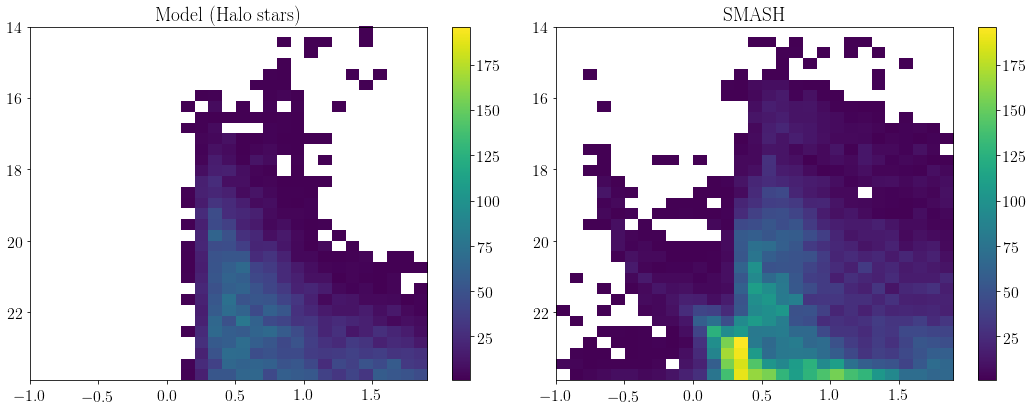

In [62]:
print(len(modelG), len(magG_0))
#hist2d_data = np.histogram2d(smash_data[0], smash_data[1], bins = [xbins,ybins])
#hist2d_model = np.histogram2d(modelGI, modelG, bins = [xbins,ybins], range = [[min(smash_data[0]), max(smash_data[0])],[min(smash_data[1]), max(smash_data[1])]])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(111)
plt.subplot(1, 2, 1)
plt.title('Model (Halo stars)')
vertex_list = [list(x) for x in halo_vertex_coord]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange', zorder =3)
ax.add_patch(polygon)
plt.hist2d(modelGI, modelG, bins = [xbins,ybins], cmin = 1, cmap='viridis', zorder = 2, vmax=196)
#plt.hist2d(GminusI_0, magG_0, bins = [xbins,ybins], cmin = 1)
plt.gca().invert_yaxis()
#plt.clim(1, 210)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('SMASH')
plt.hist2d(GminusI_0, magG_0, bins = [xbins,ybins], cmin = 1, cmap='viridis')
plt.gca().invert_yaxis()
#plt.clim(1, 210)
plt.colorbar()

plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/Field%s_ModelvsSMASH.png' % (field_number))
plt.tight_layout()
plt.show()
plt.close()

Halo scaling in region of interest

196.0


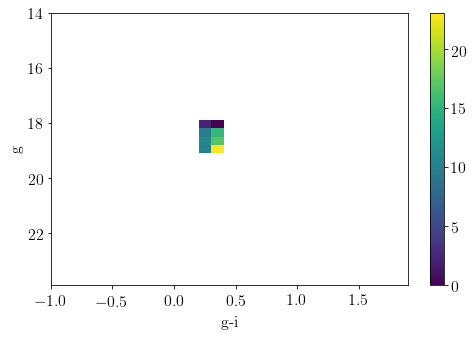

88.26946183838385 51.0
1.7307737615369383


In [55]:
# Step 1. Create an histogram of the model and the data
hist2d_model = np.histogram2d(modelGI, modelG, bins = [xbins,ybins])
hist2d_data = np.histogram2d(GminusI_0, magG_0, bins = [xbins,ybins])
print(np.max(hist2d_data[0]))

# Step 2. Set up the region of interest.
mags = hist2d_model[2][:-1] + ybinsize/2.
clrs = hist2d_model[1][:-1] + xbinsize/2.
x, y = np.meshgrid(clrs,mags)
x, y = x.flatten(), y.flatten()
cells = np.vstack((x,y)).T
#vertex_coord = [(0.2, 18), (0.4, 18), (0.4, 19), (0.2, 19)] # This is what defines the vertices of the region to be defined.
path = Path(halo_vertex_coord)
grid = path.contains_points(cells)
grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
grid = ~np.array(grid)

# Step 3. Create a new cut histogram
hist_model = completeness_corrector(field_number, hist2d_model[0], 2.53987)
cut_hist2d_model = np.ma.masked_array(hist_model, mask=grid.T)
cut_hist2d_data = np.ma.masked_array(hist2d_data[0], mask=grid.T)

# Optional step. Check the results
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)

check_hist = ax.imshow(cut_hist2d_model.T, aspect = 'auto', origin = 'upper', extent = (min(hist2d_model[1]), max(hist2d_model[1]), max(hist2d_model[2]), min(hist2d_model[2])))
#vertex_list = [list(x) for x in halo_vertex_coord]
#vertex_array = np.array(vertex_list)
#polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
#ax.add_patch(polygon)
plt.ylabel('g')
plt.xlabel('g-i')
cbd = plt.colorbar(check_hist)
plt.show()
plt.close()

# Step 4. Counting the number of stars in the region of interest.
stars_model = np.sum(cut_hist2d_model)
stars_data = np.sum(cut_hist2d_data)
print(stars_model, stars_data)

#Step 5. Final result.
print(stars_model/stars_data)


# Testing of number of halo stars as a function of distance to the SMC

In [151]:
scales = []
for field in field_list:
    name_field_model = '/scratch/MODELS/CMD_field%s_mesa.txt' % (field)
    if field == '4' or field == '9' or field == '1':
        name_field_data = '/scratch/SMASH_DATA/Field%s_allobj_stars.fits' % (field)
    else:
        name_field_data = '/scratch/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field)
    data, header = read_fits(name_field_data)
    magG = data['G']
    magI = data['I']
    EBV = data['EBV']
    magG_0, magI_0 = dereddener(magG, 1, EBV), dereddener(magI, 3, EBV)
    model = read_txt(name_field_model)
    scales.append(halo_scaler(model, magG_0, magI_0, field))
    print field, scales[-1]
    

1 0.49547101449275355
2 2.4152542372881354
3 0.7539149888143176
4 2.9619565217391304
5 0.20333333333333334
6 0.023823477179897
7 0.5534313725490195
8 1.433921568627451
9 1.2158119658119657
10 0.0394910574960989
11 0.10035005834305717
12 0.8753387533875338
13 2.344086021505376
14 0.7426900584795321
15 0.4877567140600316
16 0.4275362318840579
17 1.2817745803357314
18 1.0677083333333333
19 1.176797385620915
20 2.0418079096045196
21 0.8824273072060683
22 2.286111111111111
23 1.025229357798165
24 1.5633802816901408
25 1.3006493506493506
26 1.2602693602693602
33 0.6050254452926208
62 0.9276094276094276
130 0.8117647058823527
131 0.8453177257525084
132 0.8495614035087719
133 0.7522035256410257
134 0.8405797101449274
135 0.8397350993377484
136 3.3014184397163118
137 1.6727272727272726
138 1.9285714285714286
139 2.372448979591837
140 1.3446875
141 1.3590476190476188
142 1.7720326936744848
143 2.246341463414634
144 2.4254901960784316
145 0.9671916010498688
147 0.847972972972973
148 2.25784313725

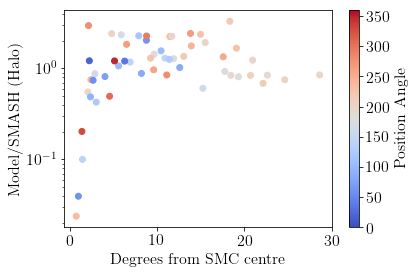

In [152]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':16})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')

fields_coord = field_coord_SMC.T
plot = ax.scatter(fields_coord[1], scales, c = fields_coord[2], cmap=cm.coolwarm, vmin = 0, vmax = 360)
cb = plt.colorbar(plot)
cb.set_label('Position Angle')
plt.xlabel('Degrees from SMC centre')
plt.ylabel('Model/SMASH (Halo)')
plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/Halo_scaling_mesa.png')
plt.show()
plt.close()

In [17]:
SMC_center = SkyCoord('0h52m44s', '-72d49m42s')
SMC_center

<SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)>

# Pretty plot for Noelia's talk

In [73]:
SB_data = np.loadtxt('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/SB_data_errors_mesa_decam.dat')
print SB_data

[[1.000000e+00 4.543000e+00 3.066610e+02 2.885762e+01 4.609500e-01]
 [2.000000e+00 4.775000e+00 2.032150e+02 2.921056e+01 4.685900e-01]
 [3.000000e+00 2.388000e+00 2.380140e+02 2.551456e+01 1.092800e-01]
 [4.000000e+00 2.122000e+00 2.787050e+02 2.573718e+01 1.111700e-01]
 [5.000000e+00 1.367000e+00 3.302200e+02 2.522862e+01 1.092400e-01]
 [6.000000e+00 7.180000e-01 2.354230e+02 2.353854e+01 1.099200e-01]
 [7.000000e+00 2.047000e+00 1.942320e+02 2.517590e+01 1.093900e-01]
 [8.000000e+00 9.646000e+00 1.804220e+02 2.967705e+01 1.059800e+00]
 [9.000000e+00 2.217000e+00 1.895300e+01 2.622848e+01 1.098600e-01]
 [1.000000e+01 9.620000e-01 5.907200e+01 2.396886e+01 1.095000e-01]
 [1.100000e+01 1.433000e+00 1.395430e+02 2.436406e+01 1.097000e-01]
 [1.200000e+01 2.851000e+00 1.587660e+02 2.662422e+01 1.118900e-01]
 [1.300000e+01 5.879000e+00 1.678580e+02 2.940782e+01 3.478000e-01]
 [1.400000e+01 2.648000e+00 5.702600e+01 2.596905e+01 1.099700e-01]
 [1.500000e+01 2.348000e+00 9.372000e+01 2.53781

In [141]:
# We decided to make the plot in Cartesian coordinates, where the centre is the centre of the SMC.
# So, we convert our polar coordinates to cartesian.
smc_x = SB_data[:,1] * np.cos(np.deg2rad(SB_data[:,2])+np.pi/2)
smc_y = SB_data[:,1] * np.sin(np.deg2rad(SB_data[:,2])+np.pi/2)
points = np.stack((smc_x, smc_y)).T
print points.shape
mesh_x, mesh_y = np.meshgrid(smc_x, smc_y)

(40, 2)


[28.85762 29.21056 25.51456 25.73718 25.22862 23.53854 25.1759  29.67705
 26.22848 23.96886 24.36406 26.62422 29.40782 25.96905 25.37814 26.80786
 29.25838 28.07691 28.8019  30.38216 29.88776 30.34851 30.07861 29.73304
 28.98385 28.89019 29.6059  29.92115 29.6661  30.51941 31.00938 30.33813
 29.8591  29.22963 29.50243 30.4838  28.51288 29.32661 27.12309 29.4179 ]
-1959.8008077138568


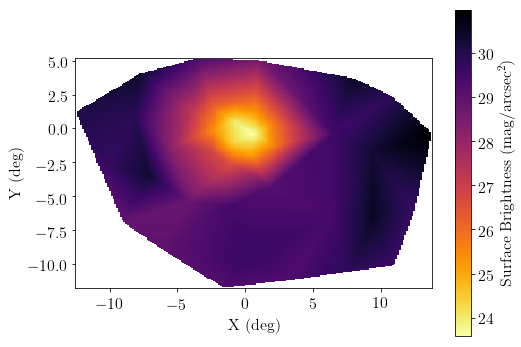

In [152]:

#x_grid, y_grid = np.meshgrid(smc_x, smc_y)
new_x = np.linspace(np.min(smc_x), np.max(smc_x), 200)
new_y = np.linspace(np.min(smc_y), np.max(smc_y), 200)
x_grid, y_grid = np.meshgrid(new_x,new_y)

#f = interpolate.interp2d(smc_x, smc_y, SB_data[:,3], kind = 'quintic')
inter_results = interpolate.griddata(points, SB_data[:,3], (x_grid, y_grid))

print SB_data[:,3]
new_z = f(new_x, new_y)
print np.min(new_z)
#print f([0,1], [0,1])

fig = plt.figure(figsize = (8,6))
#plt.scatter(smc_x, smc_y, c = SB_data[:,3], cmap = 'inferno_r', s = 200)

plt.imshow(inter_results, cmap = 'inferno_r', extent = [np.min(smc_x), np.max(smc_x), np.min(smc_y), np.max(smc_y)], origin = 'lower')
plt.xlabel('X (deg)')
plt.ylabel('Y (deg)')
cb_legend = plt.colorbar()
cb_legend.set_label('Surface Brightness (mag/arcsec$^2$)')

plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/SMC_map.png')
plt.show()
plt.close()

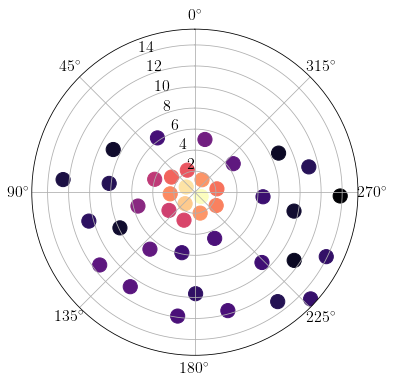

In [111]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111, projection = 'polar')
ax.scatter(np.deg2rad(SB_data[:,2]), SB_data[:,1], c = SB_data[:,3], cmap = 'magma_r', s = 200)
ax.set_rmax(15.5)
ax.set_theta_zero_location("N")
#ax.grid(False)
plt.show()